<a href="https://colab.research.google.com/github/razla/Attackar-Attack-of-the-Evolutionary-Adversary/blob/master/tree/main/Image%2520Classification/Stateless%2520Detectors/Notebooks/FeatureSqueezing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Feature Squeezing: Detecting Adversarial Examples in Deep Neural Networks**

https://arxiv.org/abs/1704.01155

Implementation of the above paper using pytorch.


## Downloading ART package


In [ ]:
!pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 25.9 MB/s 
     |████████████████████████████████| 3.3 MB 59.9 MB/s 
     |████████████████████████████████| 34.5 MB 9.6 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


## Import ART
Checking if ART package was downloaded and installed correctly.


In [ ]:
import art

## Hyperparameters for model training

In [ ]:
BATCH_SIZE = 256
LR = 0.001

## Load MNIST dataset
Dataset is taken from torchvision


In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torch

# train_set = MNIST(root = './', train = True, transform = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.1307), (0.3081))]), download = True)
# test_set = MNIST(root = './', train = False, transform = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.1307), (0.3081))]), download = True)

train_set = MNIST(root = './', train = True, transform = transforms.Compose([ transforms.ToTensor()]), download = True)
test_set = MNIST(root = './', train = False, transform = transforms.Compose([ transforms.ToTensor()]), download = True)

train_loader = DataLoader(dataset = train_set, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = test_set, batch_size = BATCH_SIZE, shuffle = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Create model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# PyTorch models inherit from torch.nn.Module
class ConvClassifier(nn.Module):
    def __init__(self):
        super(ConvClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = ConvClassifier().to(device)

## Loss function
Check if loss function works properly

In [ ]:
loss_fn = nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.8659, 0.2006, 0.1860, 0.3095, 0.2785, 0.1714, 0.3105, 0.8904, 0.7120,
         0.9705],
        [0.3802, 0.5357, 0.5940, 0.5253, 0.3081, 0.9889, 0.0598, 0.6739, 0.6443,
         0.1065],
        [0.6656, 0.2681, 0.3593, 0.3844, 0.9994, 0.8574, 0.2506, 0.4343, 0.8817,
         0.5798],
        [0.3836, 0.2099, 0.7456, 0.7685, 0.7359, 0.0206, 0.1991, 0.4729, 0.6508,
         0.0192]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.3203234672546387


## Optimizer

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

## The training loop

In [ ]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

## Per Epoch Activity

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 30

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(test_loader):
        vinputs, vlabels = vdata
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
LOSS train 0.0 valid 0.198351189494133
EPOCH 2:
LOSS train 0.0 valid 0.09759123623371124
EPOCH 3:
LOSS train 0.0 valid 0.07326263934373856
EPOCH 4:
LOSS train 0.0 valid 0.06226429343223572
EPOCH 5:
LOSS train 0.0 valid 0.059233274310827255
EPOCH 6:
LOSS train 0.0 valid 0.04828706756234169
EPOCH 7:
LOSS train 0.0 valid 0.04348209127783775
EPOCH 8:
LOSS train 0.0 valid 0.039927054196596146
EPOCH 9:
LOSS train 0.0 valid 0.03607826679944992
EPOCH 10:
LOSS train 0.0 valid 0.03507377579808235
EPOCH 11:
LOSS train 0.0 valid 0.03595976158976555
EPOCH 12:
LOSS train 0.0 valid 0.04279918223619461
EPOCH 13:
LOSS train 0.0 valid 0.035458821803331375
EPOCH 14:
LOSS train 0.0 valid 0.034034233540296555
EPOCH 15:
LOSS train 0.0 valid 0.032912056893110275
EPOCH 16:
LOSS train 0.0 valid 0.032303422689437866
EPOCH 17:
LOSS train 0.0 valid 0.03523308038711548
EPOCH 18:
LOSS train 0.0 valid 0.033865418285131454
EPOCH 19:
LOSS train 0.0 valid 0.03963903337717056
EPOCH 20:
LOSS train 0.0 valid 0.03

## Load pretrained model
To load a saved version of the model:

In [ ]:
saved_model = ConvClassifier()
saved_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

## FGSM Attack

In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

## Testing function

In [ ]:
def test( model, device, test_loader, epsilon ):
    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        # data = transforms.Normalize((0.1307), (0.3081))(data)
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True
        
        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.cross_entropy(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        # perturbed_data = transforms.Normalize((0.1307), (0.3081))(perturbed_data)
        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

## Testing several epsilons

In [ ]:
accuracies = []
examples = []
epsilons = [0, .05, .1, .15, .2, .25, .3]

test_loader = DataLoader(
    MNIST('./', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9910 / 10000 = 0.991
Epsilon: 0.05	Test Accuracy = 9473 / 10000 = 0.9473
Epsilon: 0.1	Test Accuracy = 8125 / 10000 = 0.8125
Epsilon: 0.15	Test Accuracy = 6162 / 10000 = 0.6162
Epsilon: 0.2	Test Accuracy = 4380 / 10000 = 0.438
Epsilon: 0.25	Test Accuracy = 2927 / 10000 = 0.2927
Epsilon: 0.3	Test Accuracy = 1871 / 10000 = 0.1871


## Accuracy vs Epsilon

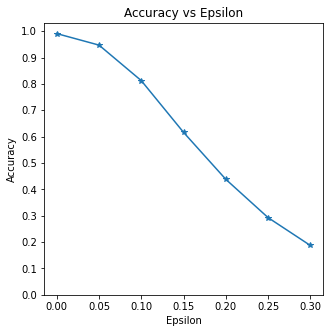

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

## Sample Adversarial Examples


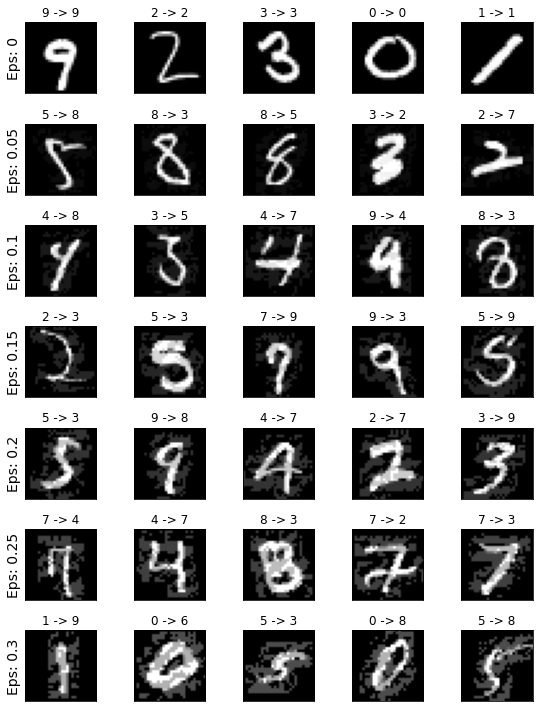

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

## Detector based on logits distance

In [ ]:
from art.defences.preprocessor import JpegCompression, FeatureSqueezing

def detector(model, epsilon, T):
    adversarial = []
    count = 0
    for i in range(len(epsilons)):
      for orig, adv, ex in examples[i][:]:
          count += 1
          # Send the data and label to the device
          ex, orig = torch.tensor(ex).unsqueeze(dim=0).to(device), torch.tensor(orig).to(device)

          output = model(ex)

          ex = ex.unsqueeze(dim=0)

          s1_x = torch.tensor(JpegCompression(clip_values=(0, 1))(ex.detach().cpu())[0]).to(device)
          s2_x = torch.tensor(FeatureSqueezing(clip_values=(0, 1))(ex.detach().cpu())[0]).to(device)

          y1_pred, y2_pred = model(s1_x), model(s2_x)
          dist1 = torch.linalg.norm((output.cpu().flatten() - y1_pred.cpu().flatten()), ord=2).item()
          dist2 = torch.linalg.norm((output.cpu().flatten() - y2_pred.cpu().flatten()), ord=2).item()

          if (max(dist1, dist2) > T):
              adversarial.append(1)
          else:
              adversarial.append(0)
    return sum(adversarial), count

## Activating the detector

In [ ]:
detected, total = detector(model, epsilon=0.1, T=0.2)
print(f'Number of adversarial examples detected is: {detected} out of: {total}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Number of adversarial examples detected is: 29 out of: 35
